# **RocketPy**

Dans cette page, nous représenterons, en utilisant la bibliothèque *RocketPy*, les différentes trajectoires des fusées en fonction du moteur utilisé. Nous étudierons trois moteurs : M2505 (le plus lourd), M3100 (un moteur modéré) et J115 (le plus léger).

Commençons par installer la bibliothèque *RocketPy* et clonons son dépôt pour obtenir les fichiers de données nécessaires :

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/giovaniceotto/RocketPy.git

     |████████████████████████████████| 88 kB 4.1 MB/s 
  Created wheel for rocketpy: filename=rocketpy-0.10.0-py3-none-any.whl size=87738 sha256=46d8e8e142787a1d36078d3237750d2e6c9befdfcde4c01ee149ccab666a9083
  Stored in directory: /root/.cache/pip/wheels/99/9a/97/4b9cdb39f1bdb1d1b3e570c32c7df06fea08102813c7cb55e0
Successfully built rocketpy
Cloning into 'RocketPy'...
remote: Enumerating objects: 3105, done.
remote: Total 3105 (delta 0), reused 0 (delta 0), pack-reused 3105
Receiving objects: 100% (3105/3105), 426.28 MiB | 21.63 MiB/s, done.
Resolving deltas: 100% (1958/1958), done.
Checking out files: 100% (150/150), done.


Maintenant pour importer les modules...

In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

In [ ]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

Les lignes de code suivantes améliorent simplement la qualité des graphiques *matplotlib* utilisés par le module *rocketpy*.

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## **Maintenant, pour commencer la simulation !**

Nous devons d'abord créer un environnement. Dans ce cas, nous supposerons que la fusée est lancée depuis *Spaceport America*.

In [ ]:
Env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

Nous avons également besoin d'informations météorologiques, qui sont disponibles en ligne.

Nous demandons à *Env* d'obtenir les conditions atmosphériques nécessaires au vol...

In [ ]:
import datetime

demain = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((demain.year, demain.month, demain.day, 12))  # Heure donnée par rapport au temps UTC

In [ ]:
Env.setAtmosphericModel(type="Forecast", file="GFS")

Et voici nos informations !

Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2022-05-05 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 80.163 km
Forecast Time Period: From  2022-05-04 00:00:00  to  2022-05-20 00:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 2.51 m/s
Surface Wind Direction: 351.40°
Surface Wind Heading: 171.40°
Surface Pressure: 852.16 hPa
Surface Temperature: 287.32 K
Surface Air Density: 1.033 kg/m³
Surface Speed of Sound: 339.80 m/s


Atmospheric Model Plots


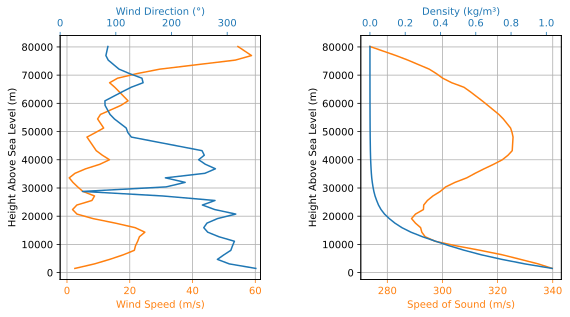

In [ ]:
Env.info()

#**Même Fusée, Différents Moteurs**

Les methodes .info() et .allInfo() des objets *SolidMotor* (moteur) et *Flight* (vol) ne nous donnent pas les informations qu'on cherche (ou trop d'information). 

On peut alors commencer par créer une classe fille *Moteur*, dans laquelle on peut redéfinir la méthode \_\_repr__ pour simplifier l'affichage. Celle-ci va imprimer les informations qu'on cherche et les graphes du moteur à partir de l'objet moteur qu'on va initialiser...

In [ ]:
class Moteur(SolidMotor):
  def __repr__(self):
    print("Details du Moteur\n")
    print("Temps Total de Combustion: " + str(self.burnOutTime) + " s") # temps total de combustion
    print(
        "Masse Totale de Propergol: "
        + "{:.3f}".format(self.propellantInitialMass)
        + " kg"
    ) # masse totale de propergol
    print(
        "Vitesse de Propergol d'Echappement: "
        + "{:.3f}".format(self.exhaustVelocity)
        + " m/s"
    ) # vitesse de propergol d'échappement
    print("Poussée moyenne: " + "{:.3f}".format(self.averageThrust) + " N") # poussée moyenne
    print(
        "Poussée maximale: "
        + str(self.maxThrust)
        + " N à "
        + str(self.maxThrustTime)
        + " s après ignition."
    ) # poussée maximale
    print("Impulsion Totale: " + "{:.3f}".format(self.totalImpulse) + " Ns") # impulsion totale

    # graphiques
    print("\nGraphiques")
    self.thrust()                   # poussée (N) x temps (s)
    self.mass()                     # masse de propergol (kg) x temps (s)
    self.burnArea()                 # surface de combustion (m^2) x temps (s)
    return ""  # la méthode __repr__ demande un retour d'une chaîne de caractères

On va également devoir créer une classe fille *Vol*, qui affichera le graphique 3D de la trajectoire du vol...

In [ ]:
class Vol(Flight):
  def __repr__(self):
    # imprimer les conditions initiales du vol
    print("Conditions initiales\n")
    self.printInitialConditionsData()

    # imprimer l'orientation du rail de lancement de la fusée
    print("\n\Orientation de Rail de Lancement")
    print("Inclination de Rail de Lancement: {:.2f}°".format(self.inclination))
    print("Direction de Rail de Lancement: {:.2f}°\n\n".format(self.heading))

    # imprimer un résumé des informations du vol
    self.info()

    # graphique 3d de la trajectoire
    print("\nTrajectoire du Vol\n")
    self.plot3dTrajectory()
    return ""  # la méthode __repr__ demande un retour d'une chaîne de caractères

## Moteur 1 : Cesaroni M2505

Nous ne travaillerons qu'avec des moteurs solides. Nous créons un objet moteur dont nous pouvons modifier les variables comme indiqué ci-dessous.

In [ ]:
M2505 = Moteur(
    thrustSource="../../data/motors/Cesaroni_7450M2505-P.eng",
    burnOut=3,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=49 / 1000,
    throatRadius=49 / 3000,
    interpolationMethod="linear",
)

Encore une fois, de l'information ! Cette fois sur le moteur.

Nous avons choisi d'afficher les graphiques qui sont les plus intéressants à regarder.

Details du Moteur

Temps Total de Combustion: 3.0 s
Masse Totale de Propergol: 2.956 kg
Vitesse de Propergol d'Echappement: 2498.314 m/s
Poussée moyenne: 2461.598 N
Poussée maximale: 2938.0 N à 1.2 s après ignition.
Impulsion Totale: 7384.795 Ns

Graphiques


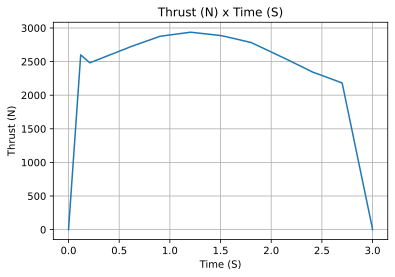

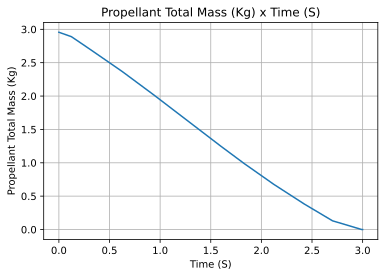

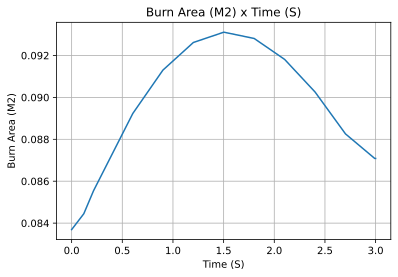

In [ ]:
print(M2505)

Maintenant que nous avons un moteur, nous pouvons maintenant créer l'objet fusée *Calisto* et quelques surfaces aérodynamiques.

In [ ]:
Calisto = Rocket(
    motor=M2505,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Calisto.setRailButtons([0.2, -0.5])

In [ ]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail = Calisto.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

Parfait ! Nous sommes prêts ! Maintenant, simulons le vol.

On peut initialiser un objet de vol et lui donner la fusée et l'environnement comme paramètres.

In [ ]:
TestVol = Vol(rocket=Calisto, environment=Env, inclination=85, heading=0)

Et voici comment se déroule notre vol !

Conditions initiales

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s

\Orientation de Rail de Lancement
Inclination de Rail de Lancement: 85.00°
Direction de Rail de Lancement: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -2.48 m/s
Lateral Surface Wind Speed: -0.37 m/s


 Rail Departure State

Rail Departure Time: 0.308 s
Rail Departure Velocity: 30.101 m/s
Rail Departure Static Margin: 2.128 c
Rail Departure Angle of Attack: 4.712°
Rail Departure Thrust-Weight Ratio: 13.684
Rail Departure Reynolds Number: 2.235e+05


BurnOut State

BurnOut time: 3.000 s
Altitude at burnOut: 577.867 m (AGL)
Rocket velocity at burnOut: 357.538 m/s
Freestream velocity at burnOut: 357.894 m/s
Mach Number at burnOut: 1.055
Kinetic energy at 

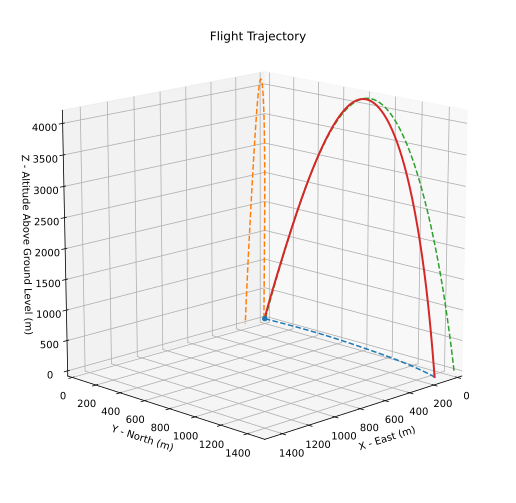

In [ ]:
print(TestVol)

On ne va réellement s'intéresser qu'à l'altitude maximale de la trajectoire. Cela correspond au *Z* projeté sur le côté gauche. On aperçoit alors que l'hauteur maximale atteinte est de **4190m**.

Mais il est aussi intéressant de voir comment la trajectoire (courbe rouge) change en fonction du temps que l'on exécute le programme (puisque les conditions de vent sont prises de valeurs réelles).

## Moteur 2 : Cesaroni M3100

On répète alors les étapes avec le moteur modéré.

In [ ]:
M3100 = Moteur(
    thrustSource="../../data/motors/Cesaroni_M3100.eng",
    burnOut=2,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=37.5 / 1000,
    throatRadius=37.5 / 3000,
    interpolationMethod="linear",
)

Details du Moteur

Temps Total de Combustion: 2.0 s
Masse Totale de Propergol: 2.956 kg
Vitesse de Propergol d'Echappement: 2074.250 m/s
Poussée moyenne: 3065.650 N
Poussée maximale: 3665.504 N à 0.817 s après ignition.
Impulsion Totale: 6131.300 Ns

Graphiques


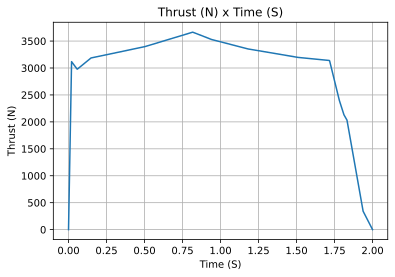

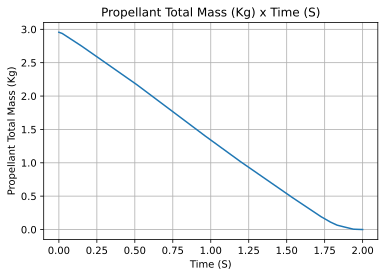

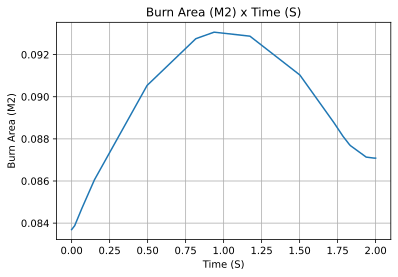

In [ ]:
print(M3100)

In [ ]:
Calisto = Rocket(
    motor=M3100,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Calisto.setRailButtons([0.2, -0.5])

In [ ]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail = Calisto.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

In [ ]:
TestVol = Vol(rocket=Calisto, environment=Env, inclination=85, heading=0)

Conditions initiales

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s

\Orientation de Rail de Lancement
Inclination de Rail de Lancement: 85.00°
Direction de Rail de Lancement: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -2.48 m/s
Lateral Surface Wind Speed: -0.37 m/s


 Rail Departure State

Rail Departure Time: 0.233 s
Rail Departure Velocity: 34.301 m/s
Rail Departure Static Margin: 2.154 c
Rail Departure Angle of Attack: 4.141°
Rail Departure Thrust-Weight Ratio: 17.509
Rail Departure Reynolds Number: 2.543e+05


BurnOut State

BurnOut time: 2.000 s
Altitude at burnOut: 335.667 m (AGL)
Rocket velocity at burnOut: 314.771 m/s
Freestream velocity at burnOut: 315.068 m/s
Mach Number at burnOut: 0.928
Kinetic energy at 

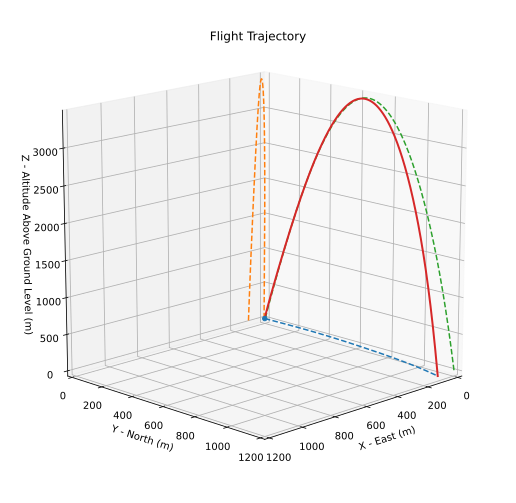

In [ ]:
print(TestVol)

Cette fois, la hauteur maximale est de **3468m**. Presque aussi haut que le moteur M2505. Pas mal.

## Moteur 3 : Cesaroni J115

Une dernière fois! On utilise le moteur très léger.

In [ ]:
J115 = Moteur(
    thrustSource="../../data/motors/Hypertek_J115.eng",
    burnOut=5.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=27 / 1000,
    throatRadius=27 / 3000,
    interpolationMethod="linear",
)

Details du Moteur

Temps Total de Combustion: 6.691 s
Masse Totale de Propergol: 2.956 kg
Vitesse de Propergol d'Echappement: 226.720 m/s
Poussée moyenne: 100.159 N
Poussée maximale: 230.563 N à 0.391 s après ignition.
Impulsion Totale: 670.164 Ns

Graphiques


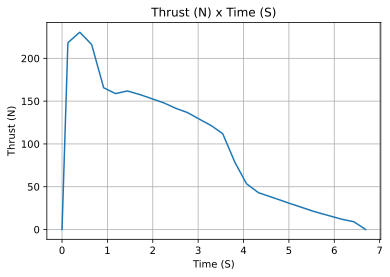

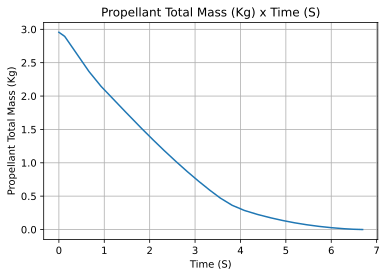

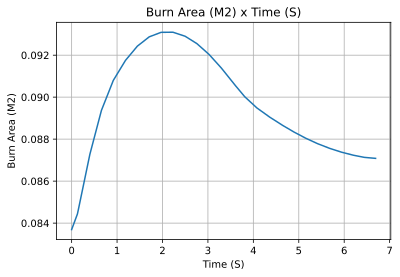

In [ ]:
print(J115)

In [ ]:
Calisto = Rocket(
    motor=J115,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Calisto.setRailButtons([0.2, -0.5])

In [ ]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail = Calisto.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

In [ ]:
TestVol = Vol(rocket=Calisto, environment=Env, inclination=85, heading=0)

Conditions initiales

Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s

\Orientation de Rail de Lancement
Inclination de Rail de Lancement: 85.00°
Direction de Rail de Lancement: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -2.48 m/s
Lateral Surface Wind Speed: -0.37 m/s


 Rail Departure State

Rail Departure Time: 3.352 s
Rail Departure Velocity: 1.284 m/s
Rail Departure Static Margin: 2.859 c
Rail Departure Angle of Attack: 59.016°
Rail Departure Thrust-Weight Ratio: 0.722
Rail Departure Reynolds Number: 2.142e+04


BurnOut State

BurnOut time: 6.691 s
Altitude at burnOut: 109.358 m (AGL)
Rocket velocity at burnOut: 7.640 m/s
Freestream velocity at burnOut: 8.190 m/s
Mach Number at burnOut: 0.024
Kinetic energy at burnO

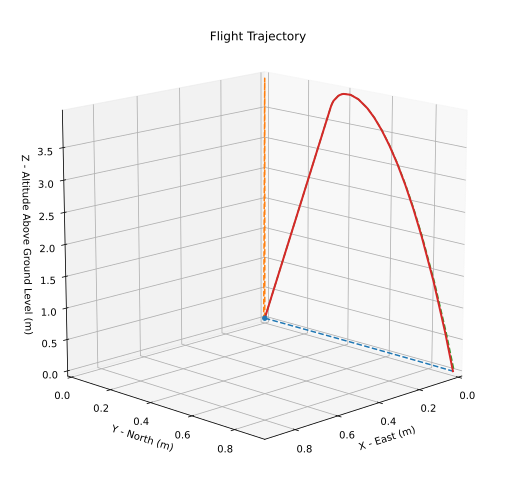

In [ ]:
print(TestVol)

La hauteur maximale est de **moins de 4m**. On voit alors bien que le moteur J115 ne serait pas convenable pour créer une fusée efficace.

Le moteur le plus lourd atteint la hauteur la plus haute, mais à l'échelle d'une fusée réelle, il coûterait beaucoup plus, ayant une masse si élevée. On pourrait donc considérer que le moteur modéré est le plus convenable, puisqu'il atteint quand même une altitude impressionnante et est moins lourd que le M2505.

Mais bien sûr il faut se rappeler que ce ne sont que des simulations!